## CNN (LeNet), Data: EMNIST

**READ ME**

 Before running the code, make sure that data folder and code are in the same directory, and the data folder needs to contain four decompressed input files, which are named as ‘emnist-byclass-test-images-idx3-ubyte’, ‘emnist-byclass-test-labels-idx1-ubyte’, ‘emnist-byclass-train-images-idx3-ubyte’, ‘emnist-byclass-train-labels-idx1-ubyte’.
The code cells in the Setup and Preprocessing parts need to be run one by one. If you want to explore the whole building model step completely, you can run all the code cells in Build and tunning model one by one. If you only want to get the final tunned model, then you can run the summary module directly. Then run the complete prediction to predict on the test set.


## Setup

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# To plot pretty figure
%matplotlib inline

keras.backend.clear_session()
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Data direction
train_data_dir='data/emnist-byclass-train-images-idx3-ubyte'
train_label_dir = 'data/emnist-byclass-train-labels-idx1-ubyte'
test_data_dir = 'data/emnist-byclass-test-images-idx3-ubyte'
test_label_dir = 'data/emnist-byclass-test-labels-idx1-ubyte'

# Read binary image data
def decode_idx3_ubyte(file):
    '''
    file: file dirction
    return: data set
    '''

    # read binary data
    bin_read_data = open(file,'rb').read()
    offset = 0
    header = '>iiii'
    magic_num, num_img, num_row, num_col = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d, image size: %d*%d' % (magic_num, num_img, num_row, num_col ))
    img_size = num_row * num_col
    offset += struct.calcsize(header)
    print(offset)
    fmt_image = '>' + str(img_size) + 'B'
    print(fmt_image, offset, struct.calcsize(fmt_image))
    images = np.empty((num_img, num_row, num_col))

    for i in range(num_img):
        if (i +1) % 10000 == 0:
            print('Decode: %d' % (i+1))
            print(offset)
        images[i] = np.array(struct.unpack_from(fmt_image, bin_read_data, offset)).reshape((num_row, num_col))
        offset += struct.calcsize(fmt_image)
    return images

# Read binary data
def decode_idx1_ubyte(file):
    '''
    file: file dirction
    return: data set
    '''
    bin_read_data = open(file, 'rb').read()
    offset = 0
    header = '>ii'
    magic_num, num_img = struct.unpack_from(header, bin_read_data,offset)
    print('magic number: %d, number of images: %d' % (magic_num, num_img))

    offset += struct.calcsize(header)
    fmt_img ='>B'
    labels = np.empty(num_img)
    for i in range(num_img):
        if (i + 1) % 10000 ==0:
            print('Decode: %d' %(i+1))
        labels[i] = struct.unpack_from(fmt_img,bin_read_data,offset)[0]
        offset += struct.calcsize(fmt_img)
    return labels


### Data loading

In [2]:
trian_img_raw = decode_idx3_ubyte(train_data_dir)
test_img_raw = decode_idx3_ubyte(test_data_dir)

magic number: 2051, number of images: 697932, image size: 28*28
16
>784B 16 784
Decode: 10000
7839232
Decode: 20000
15679232
Decode: 30000
23519232
Decode: 40000
31359232
Decode: 50000
39199232
Decode: 60000
47039232
Decode: 70000
54879232
Decode: 80000
62719232
Decode: 90000
70559232
Decode: 100000
78399232
Decode: 110000
86239232
Decode: 120000
94079232
Decode: 130000
101919232
Decode: 140000
109759232
Decode: 150000
117599232
Decode: 160000
125439232
Decode: 170000
133279232
Decode: 180000
141119232
Decode: 190000
148959232
Decode: 200000
156799232
Decode: 210000
164639232
Decode: 220000
172479232
Decode: 230000
180319232
Decode: 240000
188159232
Decode: 250000
195999232
Decode: 260000
203839232
Decode: 270000
211679232
Decode: 280000
219519232
Decode: 290000
227359232
Decode: 300000
235199232
Decode: 310000
243039232
Decode: 320000
250879232
Decode: 330000
258719232
Decode: 340000
266559232
Decode: 350000
274399232
Decode: 360000
282239232
Decode: 370000
290079232
Decode: 380000
29

In [3]:
train_lab_raw = decode_idx1_ubyte(train_label_dir)
test_lab_raw = decode_idx1_ubyte(test_label_dir)

magic number: 2049, number of images: 697932
Decode: 10000
Decode: 20000
Decode: 30000
Decode: 40000
Decode: 50000
Decode: 60000
Decode: 70000
Decode: 80000
Decode: 90000
Decode: 100000
Decode: 110000
Decode: 120000
Decode: 130000
Decode: 140000
Decode: 150000
Decode: 160000
Decode: 170000
Decode: 180000
Decode: 190000
Decode: 200000
Decode: 210000
Decode: 220000
Decode: 230000
Decode: 240000
Decode: 250000
Decode: 260000
Decode: 270000
Decode: 280000
Decode: 290000
Decode: 300000
Decode: 310000
Decode: 320000
Decode: 330000
Decode: 340000
Decode: 350000
Decode: 360000
Decode: 370000
Decode: 380000
Decode: 390000
Decode: 400000
Decode: 410000
Decode: 420000
Decode: 430000
Decode: 440000
Decode: 450000
Decode: 460000
Decode: 470000
Decode: 480000
Decode: 490000
Decode: 500000
Decode: 510000
Decode: 520000
Decode: 530000
Decode: 540000
Decode: 550000
Decode: 560000
Decode: 570000
Decode: 580000
Decode: 590000
Decode: 600000
Decode: 610000
Decode: 620000
Decode: 630000
Decode: 640000
Deco

## Preprocess data

### Scale data

In [4]:
# Scale the data to the range 0-1
trian_img_raw = trian_img_raw / 255.
test_img_raw =test_img_raw / 255.
print('Shape of X_train:{}'.format(trian_img_raw.shape))

Shape of X_train:(697932, 28, 28)


### View all labels

In [ ]:
print(np.unique(train_lab_raw))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]


### Split training set into training set and validation set

In [6]:
X_train, X_val, y_train, y_val = train_test_split(trian_img_raw,train_lab_raw,random_state=42)

In [7]:
# Add an extra dimension to our data
X_train_sc = np.expand_dims(X_train, -1)
X_val_sc = np.expand_dims(X_val, -1)
X_test_sc = np.expand_dims(test_img_raw, -1)

print(f"New shape of X_train: {X_train_sc.shape}")

New shape of X_train: (523449, 28, 28, 1)


## CNN model using Keras

##### Baseline CNN model [CONV-POOL-CONV-POOL-FC-FC]

In [7]:
model = keras.Sequential([   
    # Specify the input shape
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(16,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

# Compile model with loss, optimiser, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])


# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = model.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val))

2022-05-14 17:09:16.683296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
4090/4090 [==============================] - 167s 41ms/step - loss: 2.1685 - accuracy: 0.4850 - val_loss: 1.3110 - val_accuracy: 0.6446
Epoch 2/10
4090/4090 [==============================] - 154s 38ms/step - loss: 1.1458 - accuracy: 0.6791 - val_loss: 1.0054 - val_accuracy: 0.7105
Epoch 3/10
4090/4090 [==============================] - 155s 38ms/step - loss: 0.9405 - accuracy: 0.7257 - val_loss: 0.8641 - val_accuracy: 0.7443
Epoch 4/10
4090/4090 [==============================] - 157s 38ms/step - loss: 0.8277 - accuracy: 0.7519 - val_loss: 0.7774 - val_accuracy: 0.7644
Epoch 5/10
4090/4090 [==============================] - 155s 38ms/step - loss: 0.7570 - accuracy: 0.7690 - val_loss: 0.7220 - val_accuracy: 0.7788
Epoch 6/10
4090/4090 [==============================] - 162s 40ms/step - loss: 0.7090 - accuracy: 0.7803 - val_loss: 0.6856 - val_accuracy: 0.7855
Epoch 7/10
4090/4090 [==============================] - 157s 38ms/step - loss: 0.6740 - accuracy: 0.7890 - val_loss: 0

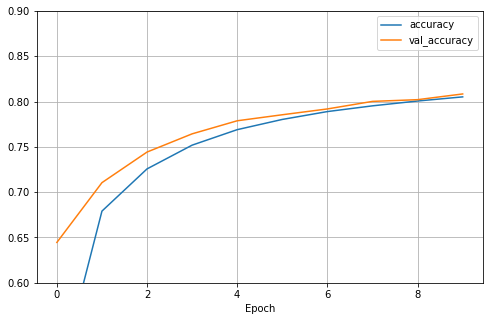

In [8]:
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.6,0.9)
plt.xlabel('Epoch')
plt.show()

##### Use sklearn grid search to turn neurons

In [ ]:
def build_cnn(n_hidden_neurons= [16,32,64]):
    """Build a Keras MLP for 62 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(28, 28, 1))),
    model.add(keras.layers.Conv2D(n_hidden_neurons[0],5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Conv2D(n_hidden_neurons[1],5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten(input_shape=(28,28,1)))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(62, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   metrics=["accuracy"])
                                
    return model


keras_classifier = KerasClassifier(build_cnn,
                                    epochs=1,
                                    n_hidden_neurons = [16,32]
                                  )


param_grid = {'n_hidden_neurons': [[16,32],[32,64],[16,64]]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=10)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/10
10906/10906 [==============================] - 126s 12ms/step - loss: 0.8423 - accuracy: 0.7468
Epoch 2/10
10906/10906 [==============================] - 122s 11ms/step - loss: 0.5004 - accuracy: 0.8278
Epoch 3/10
10906/10906 [==============================] - 109s 10ms/step - loss: 0.4445 - accuracy: 0.8427
Epoch 4/10
10906/10906 [==============================] - 108s 10ms/step - loss: 0.4157 - accuracy: 0.8509
Epoch 5/10
10906/10906 [==============================] - 107s 10ms/step - loss: 0.3962 - accuracy: 0.8562
Epoch 6/10
10906/10906 [==============================] - 108s 10ms/step - loss: 0.3814 - accuracy: 0.8607
Epoch 7/10
10906/10906 [==============================] - 110s 10ms/step - loss: 0.3696 - accuracy: 0.8637
Epoch 8/10
10906/10906 [==============================] - 107s 10ms/step - loss: 0.3592 - accuracy: 0.8662
Epoch 9/10
10906/10906 [==============================] - 106s 10ms/step - loss: 0.35

In [ ]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.85305 (+/-0.006) for {'n_hidden_neurons': [16, 32]}
0.85503 (+/-0.003) for {'n_hidden_neurons': [32, 64]}
0.85337 (+/-0.006) for {'n_hidden_neurons': [16, 64]}
Best parameters:  {'n_hidden_neurons': [32, 64]}


##### view current model performance

In [ ]:
CNN_model_2 = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')

])

CNN_model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = CNN_model_2.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val))

Epoch 1/10
4090/4090 [==============================] - 204s 50ms/step - loss: 1.1259 - accuracy: 0.6892 - val_loss: 0.6779 - val_accuracy: 0.7820
Epoch 2/10
4090/4090 [==============================] - 192s 47ms/step - loss: 0.5882 - accuracy: 0.8073 - val_loss: 0.5604 - val_accuracy: 0.8119
Epoch 3/10
4090/4090 [==============================] - 197s 48ms/step - loss: 0.5091 - accuracy: 0.8267 - val_loss: 0.4986 - val_accuracy: 0.8287
Epoch 4/10
4090/4090 [==============================] - 189s 46ms/step - loss: 0.4693 - accuracy: 0.8376 - val_loss: 0.4699 - val_accuracy: 0.8350
Epoch 5/10
4090/4090 [==============================] - 189s 46ms/step - loss: 0.4449 - accuracy: 0.8442 - val_loss: 0.4472 - val_accuracy: 0.8439
Epoch 6/10
4090/4090 [==============================] - 201s 49ms/step - loss: 0.4271 - accuracy: 0.8488 - val_loss: 0.4424 - val_accuracy: 0.8439
Epoch 7/10
4090/4090 [==============================] - 186s 45ms/step - loss: 0.4139 - accuracy: 0.8522 - val_loss: 0

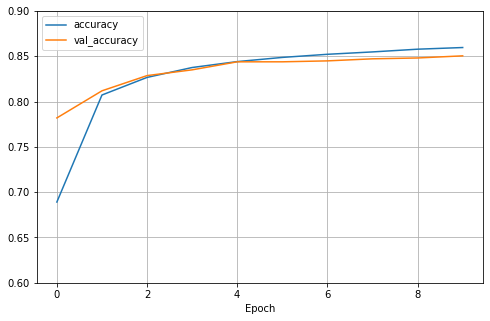

In [ ]:
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.6,0.9)
plt.xlabel('Epoch')
plt.show()

##### Use sklearn grid search to choose the best optimizer

In [ ]:
def build_cnn():
    """Build a Keras CNN for 62 class classification with desired parameters."""
  
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(32,5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Conv2D(64,5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten(input_shape=(28,28,1)))
    model.add(keras.layers.Dense(512,activation='relu'))
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(62,activation='softmax'))
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer='sgd',
                                   metrics=["accuracy"])
    return model

keras_classifier = KerasClassifier(build_cnn,epochs=1)
param_grid = {'optimizer': ['SGD','RMSprop', 'Adam']}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=10)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/10
10906/10906 [==============================] - 157s 14ms/step - loss: 1.1844 - accuracy: 0.6581
Epoch 2/10
10906/10906 [==============================] - 158s 15ms/step - loss: 0.6206 - accuracy: 0.7921
Epoch 3/10
10906/10906 [==============================] - 134s 12ms/step - loss: 0.5416 - accuracy: 0.8134
Epoch 4/10
10906/10906 [==============================] - 131s 12ms/step - loss: 0.5030 - accuracy: 0.8238
Epoch 5/10
10906/10906 [==============================] - 132s 12ms/step - loss: 0.4778 - accuracy: 0.8306
Epoch 6/10
10906/10906 [==============================] - 131s 12ms/step - loss: 0.4587 - accuracy: 0.8365
Epoch 7/10
10906/10906 [==============================] - 133s 12ms/step - loss: 0.4449 - accuracy: 0.8398
Epoch 8/10
10906/10906 [==============================] - 131s 12ms/step - loss: 0.4333 - accuracy: 0.8439
Epoch 9/10
10906/10906 [==============================] - 131s 12ms/step - loss: 0.42

In [ ]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.83830 (+/-0.005) for {'optimizer': 'SGD'}
0.83703 (+/-0.008) for {'optimizer': 'RMSprop'}
0.83847 (+/-0.004) for {'optimizer': 'Adam'}
Best parameters:  {'optimizer': 'Adam'}


##### Use sklearn grid search to choose learning rate

In [ ]:
def build_cnn():
    """Build a Keras CNN for 62 class classification with desired parameters."""
    
    # Specify the input shape
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(28, 28, 1)))
    model.add(keras.layers.Conv2D(32,5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Conv2D(64,5))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten(input_shape=(28,28,1)))
    model.add(keras.layers.Dense(512,activation='relu'))
    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(62,activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])
    return model

keras_classifier = KerasClassifier(build_cnn,epochs=1)
from sklearn.model_selection import GridSearchCV
param_grid = {'optimizer__lr': [0.0001,0.001]}
grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=10)
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

Fitting 3 folds for each of 2 candidates, totalling 6 fits


2022-05-04 20:29:02.266197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
10906/10906 [==============================] - 163s 15ms/step - loss: 0.7054 - accuracy: 0.7752
Epoch 2/10
10906/10906 [==============================] - 149s 14ms/step - loss: 0.6380 - accuracy: 0.7985
Epoch 3/10
10906/10906 [==============================] - 157s 14ms/step - loss: 0.6903 - accuracy: 0.7882
Epoch 4/10
10906/10906 [==============================] - 150s 14ms/step - loss: 0.7371 - accuracy: 0.7819
Epoch 5/10
10906/10906 [==============================] - 145s 13ms/step - loss: 0.7793 - accuracy: 0.7745
Epoch 6/10
10906/10906 [==============================] - 142s 13ms/step - loss: 0.8383 - accuracy: 0.7653
Epoch 7/10
10906/10906 [==============================] - 144s 13ms/step - loss: 0.9024 - accuracy: 0.7559
Epoch 8/10
10906/10906 [==============================] - 143s 13ms/step - loss: 0.9595 - accuracy: 0.7453
Epoch 9/10
10906/10906 [==============================] - 141s 13ms/step - loss: 1.0367 - accuracy: 0.7334
Epoch 10/10
5453/5453 [==============

In [ ]:
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_cv.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters: ', grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

0.69166 (+/-0.088) for {'optimizer__lr': 0.0001}
0.69803 (+/-0.011) for {'optimizer__lr': 0.001}
Best parameters:  {'optimizer__lr': 0.001}


##### View current model

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])   


batch_size = 128
epochs = 10

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto'
)

# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = model.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val),
                    callbacks = [early_stop_cb])



Epoch 1/10
4090/4090 [==============================] - 188s 46ms/step - loss: 0.5151 - accuracy: 0.8255 - val_loss: 0.4198 - val_accuracy: 0.8487
Epoch 2/10
4090/4090 [==============================] - 178s 43ms/step - loss: 0.3898 - accuracy: 0.8577 - val_loss: 0.3803 - val_accuracy: 0.8620
Epoch 3/10
4090/4090 [==============================] - 181s 44ms/step - loss: 0.3617 - accuracy: 0.8649 - val_loss: 0.3768 - val_accuracy: 0.8616
Epoch 4/10
4090/4090 [==============================] - 182s 44ms/step - loss: 0.3415 - accuracy: 0.8706 - val_loss: 0.3845 - val_accuracy: 0.8598
Epoch 5/10
4090/4090 [==============================] - 183s 45ms/step - loss: 0.3232 - accuracy: 0.8760 - val_loss: 0.3911 - val_accuracy: 0.8614
Epoch 6/10
4090/4090 [==============================] - 183s 45ms/step - loss: 0.3078 - accuracy: 0.8801 - val_loss: 0.3918 - val_accuracy: 0.8598
Epoch 7/10
4090/4090 [==============================] - 180s 44ms/step - loss: 0.2936 - accuracy: 0.8841 - val_loss: 0

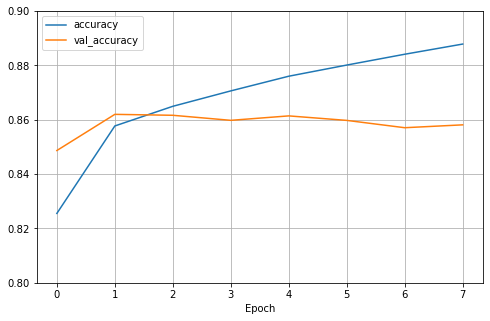

In [ ]:
import pandas as pd
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,0.90)
plt.xlabel('Epoch')
plt.show()

#### Turning dropout layer

##### Dropout rate = 0.1

In [10]:
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')

])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])   

# Train the model for 20 epochs with batch size 128
batch_size = 128
epochs = 20
history = model.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val))

Epoch 1/20
4090/4090 [==============================] - 526s 128ms/step - loss: 0.5400 - accuracy: 0.8185 - val_loss: 0.4215 - val_accuracy: 0.8489
Epoch 2/20
4090/4090 [==============================] - 526s 129ms/step - loss: 0.4095 - accuracy: 0.8519 - val_loss: 0.3873 - val_accuracy: 0.8598
Epoch 3/20
4090/4090 [==============================] - 524s 128ms/step - loss: 0.3848 - accuracy: 0.8585 - val_loss: 0.3788 - val_accuracy: 0.8602
Epoch 4/20
4090/4090 [==============================] - 524s 128ms/step - loss: 0.3677 - accuracy: 0.8633 - val_loss: 0.3763 - val_accuracy: 0.8606
Epoch 5/20
4090/4090 [==============================] - 527s 129ms/step - loss: 0.3564 - accuracy: 0.8661 - val_loss: 0.3755 - val_accuracy: 0.8635
Epoch 6/20
4090/4090 [==============================] - 530s 130ms/step - loss: 0.3464 - accuracy: 0.8688 - val_loss: 0.3795 - val_accuracy: 0.8599
Epoch 7/20
4090/4090 [==============================] - 527s 129ms/step - loss: 0.3387 - accuracy: 0.8704 - val_

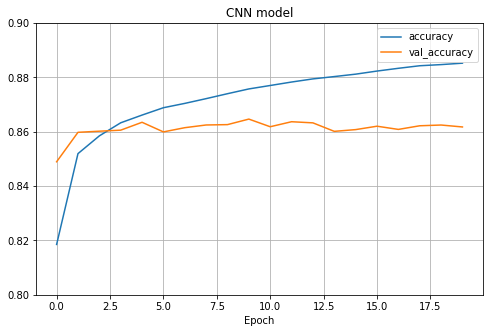

In [12]:
import pandas as pd
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,0.9)
plt.xlabel('Epoch')
plt.title('CNN model')
plt.show()

##### Dropout rate = 0.2

In [9]:
time_start =time.time()
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')

])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])  

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto'
)
# Train the model for 20 epochs with batch size 128
batch_size = 128
epochs = 20
history = model.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val),
                    callbacks = [early_stop_cb])
time_end=time.time()
time_c =time_end - time_start
print('time cost',time_c,'s')

Epoch 1/20
4090/4090 [==============================] - 288s 70ms/step - loss: 0.5658 - accuracy: 0.8109 - val_loss: 0.4040 - val_accuracy: 0.8524
Epoch 2/20
4090/4090 [==============================] - 263s 64ms/step - loss: 0.4178 - accuracy: 0.8496 - val_loss: 0.3712 - val_accuracy: 0.8641
Epoch 3/20
4090/4090 [==============================] - 259s 63ms/step - loss: 0.3935 - accuracy: 0.8559 - val_loss: 0.3634 - val_accuracy: 0.8647
Epoch 4/20
4090/4090 [==============================] - 257s 63ms/step - loss: 0.3798 - accuracy: 0.8597 - val_loss: 0.3613 - val_accuracy: 0.8642
Epoch 5/20
4090/4090 [==============================] - 275s 67ms/step - loss: 0.3696 - accuracy: 0.8625 - val_loss: 0.3537 - val_accuracy: 0.8683
Epoch 6/20
4090/4090 [==============================] - 286s 70ms/step - loss: 0.3636 - accuracy: 0.8644 - val_loss: 0.3561 - val_accuracy: 0.8666
Epoch 7/20
4090/4090 [==============================] - 265s 65ms/step - loss: 0.3577 - accuracy: 0.8658 - val_loss: 0

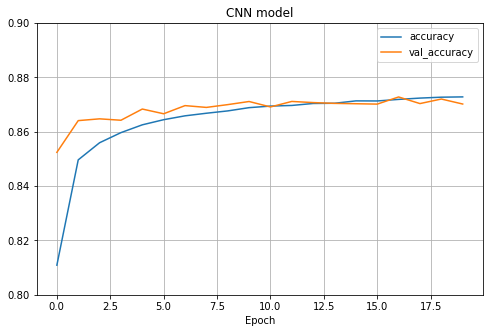

In [10]:
accuracies = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
accuracies.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,0.9)
plt.xlabel('Epoch')
plt.title('CNN model')
plt.show()

The validation set performs best when the dropout rate is 0.2, so this is set as the final model.

##### Final model

In [8]:
time_start =time.time()
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(62,activation='softmax')

])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="sparse_categorical_crossentropy",
                                   optimizer=opt,
                                   metrics=["accuracy"])  

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto'
)
# Train the model for 20 epochs with batch size 128
batch_size = 128
epochs = 20
history = model.fit(X_train_sc, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val_sc, y_val),
                    callbacks = [early_stop_cb]
                   )
time_end=time.time()
time_c =time_end - time_start
print('time cost',time_c,'s')

2022-05-20 16:45:56.872007: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
4090/4090 [==============================] - 270s 66ms/step - loss: 0.5711 - accuracy: 0.8093 - val_loss: 0.4028 - val_accuracy: 0.8527
Epoch 2/20
4090/4090 [==============================] - 401s 98ms/step - loss: 0.4191 - accuracy: 0.8493 - val_loss: 0.3720 - val_accuracy: 0.8629
Epoch 3/20
4090/4090 [==============================] - 421s 103ms/step - loss: 0.3945 - accuracy: 0.8551 - val_loss: 0.3645 - val_accuracy: 0.8640
Epoch 4/20
4090/4090 [==============================] - 226s 55ms/step - loss: 0.3806 - accuracy: 0.8596 - val_loss: 0.3649 - val_accuracy: 0.8631
Epoch 5/20
4090/4090 [==============================] - 208s 51ms/step - loss: 0.3706 - accuracy: 0.8619 - val_loss: 0.3551 - val_accuracy: 0.8683
Epoch 6/20
4090/4090 [==============================] - 205s 50ms/step - loss: 0.3634 - accuracy: 0.8639 - val_loss: 0.3549 - val_accuracy: 0.8671
Epoch 7/20
4090/4090 [==============================] - 250s 61ms/step - loss: 0.3580 - accuracy: 0.8655 - val_loss: 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)          0

In [12]:
model.save('LeNet.h5')

### Using the final model do predict on test set

In [11]:
loss,accuracy = model.evaluate(X_test_sc,test_lab_raw)
print(f'Accuracy on test data: {accuracy:.4f}')

3636/3636 [==============================] - 18s 5ms/step - loss: 0.3545 - accuracy: 0.8707
Accuracy on test data: 0.8707


#### Compare prediction and true label

Show the prediction and true label of the first 10 data

In [13]:
X_test_sample = X_test_sc
y_proba = model.predict(X_test_sample).round(2)
y_pred = np.argmax(y_proba, axis = -1)
print('Model prediction: ',y_pred[:10])
print('True label: ',test_lab_raw[:10])

Model prediction:  [ 1 36  0  3 33 30 24 40  5  8]
True label:  [18. 36.  0.  3. 33. 30. 24. 40.  5.  8.]


#### Show accuracy, precision, recall, F1 score of the prediction 

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print('The accuracy socre of CNN model is: {:.2f} '.format(accuracy_score(test_lab_raw,y_pred)))
print('The precision socre of CNN model is: {:.2f} '.format(precision_score(test_lab_raw,y_pred,average='weighted')))
print('The recall socre of CNN model is: {:.2f} '.format(recall_score(test_lab_raw,y_pred,average='weighted')))
print('The F1 socre of CNN model is: {:.2f} '.format(f1_score(test_lab_raw,y_pred,average='weighted')))

The accuracy socre of CNN model is: 0.87 
The precision socre of CNN model is: 0.86 
The recall socre of CNN model is: 0.87 
The F1 socre of CNN model is: 0.86 


#### Plot confusion mactrix

Plot confusion mactrix to observe the classification performance of the model for some categories.

Text(0.5, 1.0, 'Confusion matrix of CNN')

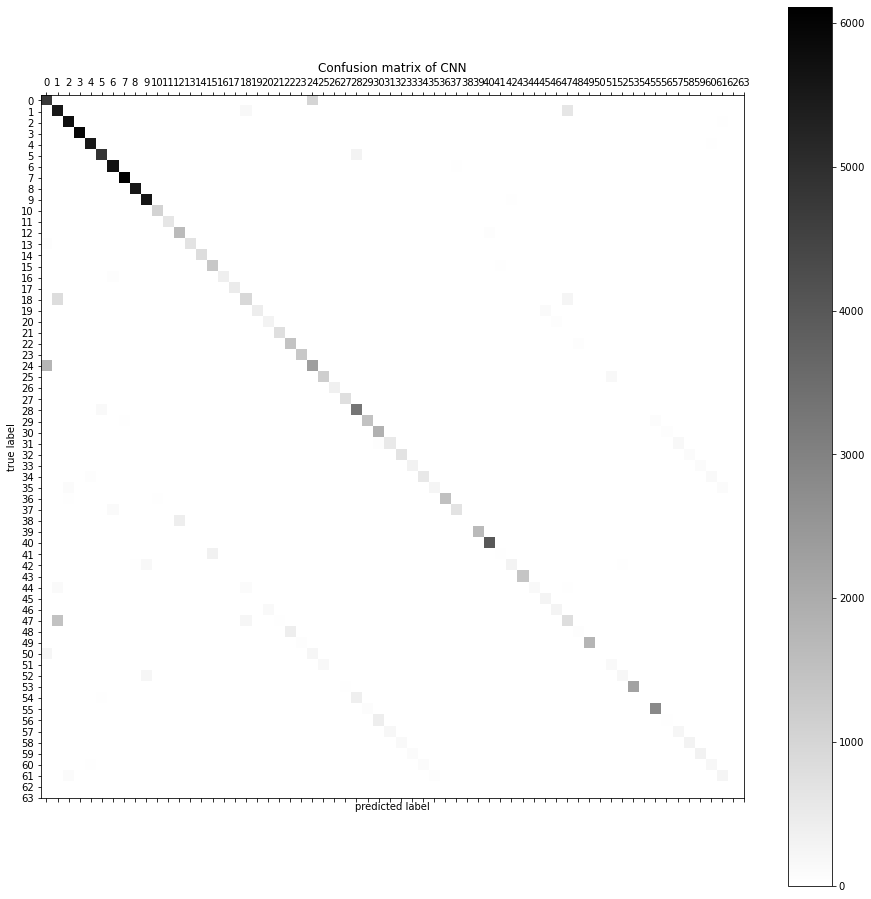

In [15]:
def cm_to_inch(value):
    return value/2.54

matfig = plt.figure(figsize=(cm_to_inch(40),cm_to_inch(40)))
plt.matshow(confusion_matrix(test_lab_raw, y_pred), cmap=plt.cm.binary, interpolation='nearest',fignum=matfig.number)
plt.colorbar()
plt.xticks(range(64))
plt.yticks(range(64))
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Confusion matrix of CNN')